In [1]:
import matplotlib.pylab as plt
import numpy as np
import matplotlib.cm as cm
import cmocean.cm as cmo
import intake

import numcodecs
try:
    import gribscan
except:
    %pip install gribscan
    import gribscan
import cfgrib
import gc

from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from dask.diagnostics import ProgressBar

from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
#from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import re
from math import radians, cos, sin, sqrt, atan2
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
import pandas as pd
import eccodes
try:
    import healpy
except:
    %pip install healpy
import json


In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")


In [72]:
#Set parameters for date and lat/lon range 

#months = [1,2,3,4,5,6,7,8,9,10,11,12]
months = [6]

years = np.arange(2020, 2051) #try smaller year range when testing your script for faster runtime

latitude = [35,45] #Choose your own lat/lon range 
longitude = [-11,35]

In [35]:

#Loading IFS data
var = ['tp'] #for cape, change to 2D_1h_0.25deg precip = tp temperature = 2t
sim = '2020-2050'  #1990-2020 or 2020-2050


data = cat.IFS['IFS_9-FESOM_5-production']['2D_monthly_healpix512'](chunks={}).to_dask().drop_duplicates('time', keep='last') # load H512, hourly; and exclude time duplicates containing NaNs

IFS_data = data[var]

In [36]:
def get_nest(dx):
    return dx.crs.healpix_order == "nest"


def get_nside(dx):
    return dx.crs.healpix_nside


def attach_coords(ds):
    lons, lats = healpy.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )
#Loading ICON data
var = ['pr'] #for cape, change to 2D_1h_0.25deg precip = pr 'crs' land_sea_mask = 'ocean_fraction_surface'

data = cat.ICON.ngc4008(chunks="auto")(time="P1D",zoom=9).to_dask().pipe(attach_coords)  #PT15M,PT3H,P1D
ICON_data = data[var]




In [59]:
print(ICON_data.pr)

<xarray.DataArray 'pr' (time: 10958, cell: 3145728)> Size: 138GB
dask.array<open_dataset-pr, shape=(10958, 3145728), dtype=float32, chunksize=(120, 262144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... -44.91 -45.09 -45.0
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface


In [73]:
#####calculate the temporal mean
def calc_mean(dataset,model,months,years,latitude,longitude):
    
    dataset['lon_adjusted'] = xr.where(dataset.lon > 180, dataset.lon - 360, dataset.lon)
    dataset['lon'] = dataset['lon_adjusted']
    dataset = dataset.reset_coords(names='lon_adjusted', drop=True)
    
   
    ###calculate
    
    dataset = dataset.where(dataset.time.dt.year.isin(years), drop=True)
    dataset = dataset.where(dataset.time.dt.month.isin(months), drop=True)
    
    indexer = ((dataset.lat>=latitude[0]) & (dataset.lat<=latitude[1]) & (dataset.lon>=longitude[0]) & (dataset.lon<=longitude[1])).compute()
    dataset = dataset.where(indexer,drop=True)

    with ProgressBar():
        dataset = dataset.load()
    if model == 'ICON':
        dataset = dataset.resample(time='1M').sum() * 86400 #ICON precip is mm/s so convert to mm/day
    elif model == 'IFS': 
        dataset = dataset * 1000 #IFS precip is m/h
    precip_mean = dataset.mean(dim='time')

    return precip_mean    
    
    

In [74]:
model = 'IFS'
IFS_mean = calc_mean(IFS_data,model,months,years,latitude,longitude)

[########################################] | 100% Completed | 437.16 ms


In [75]:
model = 'ICON'
ICON_mean = calc_mean(ICON_data,model,months,years,latitude,longitude)

[########################################] | 100% Completed | 5.82 ss


In [78]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.tri as tri


In [79]:


def subplot_scatter(data,ax,levels,cmaps,extends='max',title='',cbar_title='',ax_cbar=None,colorbar=False):
    print(data)
    triang = tri.Triangulation(data.lon, data.lat)

    plot = plt.tricontourf(triang,data.data,alpha=0.90,levels=levels,\
             cmap=plt.cm.get_cmap(cmaps), transform=ccrs.PlateCarree()) 


    cbar_tickloc = [0,50,100,150,200,250,300,350,400]
    cbar_ticklab = ['0','50','100','150','200','250','300','350','>400']

    if colorbar == True: 
        cb1 = plt.colorbar(plot,extend='max',orientation='horizontal',cax=ax_cbar,shrink=0.8,pad=0.09)
        cb1.ax.set_xlabel(cbar_title,fontsize=16)
        cb1.ax.tick_params(labelsize=16)
        cb1.set_ticks(cbar_tickloc)
        cb1.ax.set_xticklabels(cbar_ticklab)
    ax_cbar.set_position([0.2, 0.22, 0.6, 0.02])  # Adjust these values as needed
    ax.set_title(title,fontsize=18)   
    ax.coastlines(resolution='10m',linewidth=0.6)
    ax.set_extent ((-10, 35, 35, 45), crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.7, color='gray', alpha=0.8, zorder=5, linestyle='--')   # ax.set_extent([lon[0],lon[1],lat[0],lat[1]], crs=ccrs.PlateCarree())
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-30,-15,0,15,30])
    gl.ylocator = mticker.FixedLocator([36,38,40,42,44])

    gl.xlabel_style = {'size': 16,}
    gl.ylabel_style = {'size': 16,}
   # ax.set_yticks(np.arange(lat[0],lat[1]+0.1,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
   # ax.set_xticks(np.arange(lon[0], lon[1]+0.1,60),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=16)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

<xarray.DataArray 'tp' (value: 26968)> Size: 216kB
array([ 2.11106936,  1.94330215,  2.15200583, ..., 42.98826853,
       43.958052  , 44.5965449 ])
Coordinates:
    lat      (value) float64 216kB 35.04 35.04 35.04 35.14 ... 41.61 41.61 41.71
    lon      (value) float64 216kB 28.65 28.3 28.48 ... 0.08789 -0.08789 0.0
Dimensions without coordinates: value


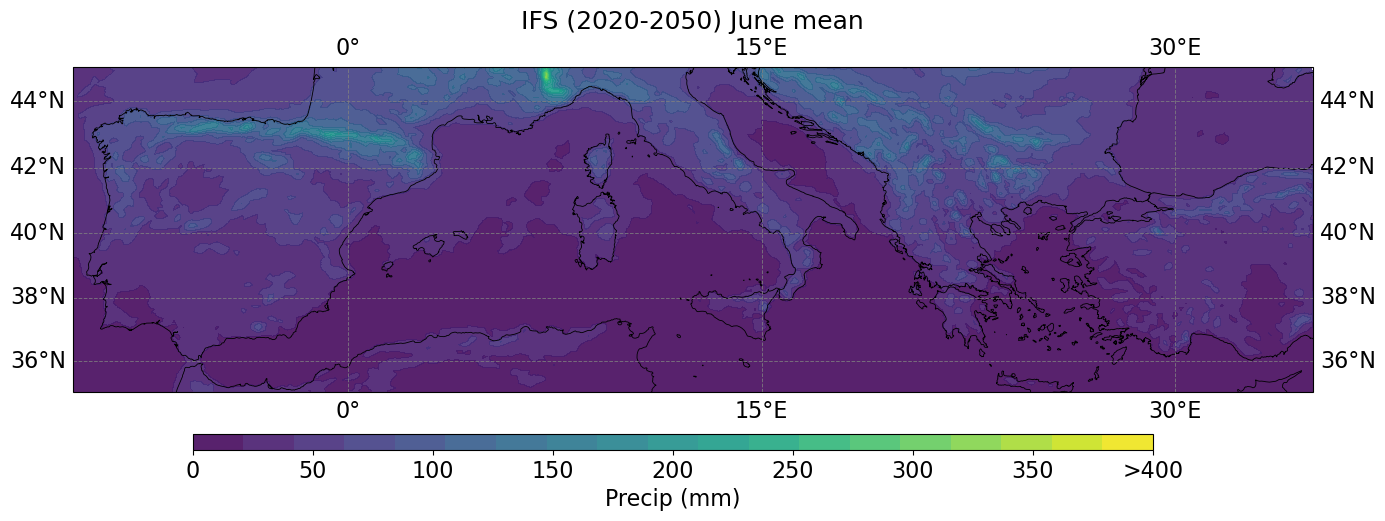

In [82]:
fig = plt.figure(figsize=(16, 8))

ax1=fig.add_axes([0.2,0.05,0.6,0.02])
ax = fig.add_subplot(111,projection=ccrs.Miller(central_longitude=0.0, globe=None))

subplot_scatter((IFS_mean.tp),ax,np.linspace(0, 400, 20),\
                'viridis','max','IFS (2020-2050) June mean',\
                'Precip (mm)',ax1,colorbar=True)  



<xarray.DataArray 'pr' (cell: 26968)> Size: 108kB
array([ 0.14900137,  0.41582426,  0.17719594, ..., 36.84702   ,
       40.945877  , 41.79589   ], dtype=float32)
Coordinates:
    lat      (cell) float64 216kB 35.04 35.04 35.04 35.14 ... 41.61 41.61 41.71
    lon      (cell) float64 216kB 28.65 28.3 28.48 ... 0.08789 -0.08789 0.0
Dimensions without coordinates: cell


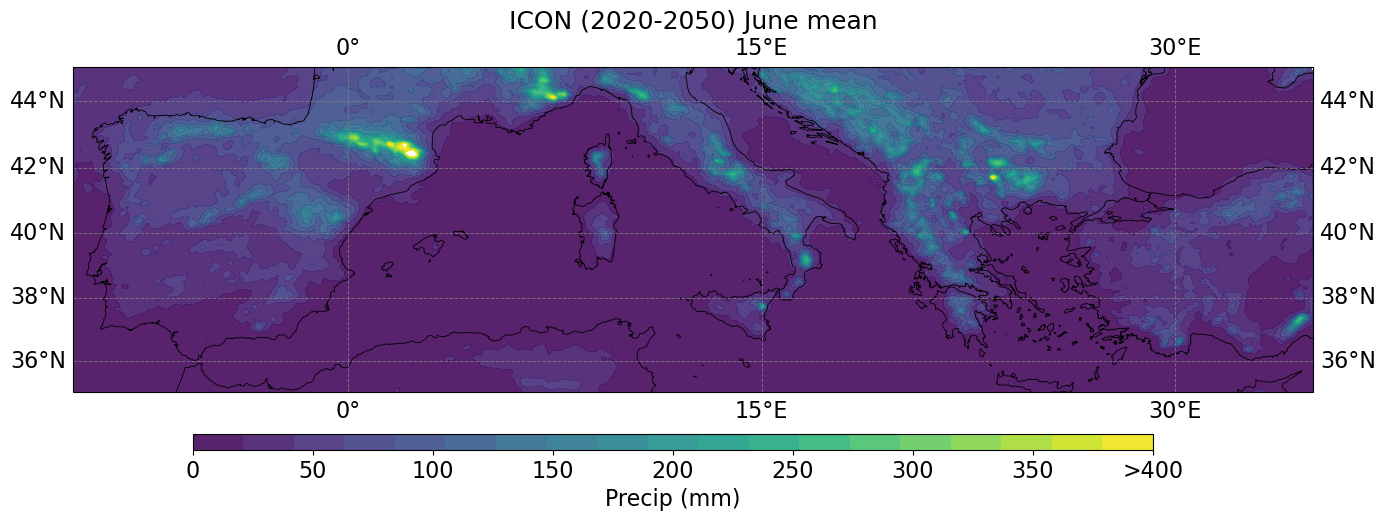

In [83]:
fig = plt.figure(figsize=(16, 8))

ax1=fig.add_axes([0.2,0.05,0.6,0.02])
ax = fig.add_subplot(111,projection=ccrs.Miller(central_longitude=0.0, globe=None))

subplot_scatter((ICON_mean.pr),ax,np.linspace(0, 400, 20),\
                'viridis','max','ICON (2020-2050) June mean',\
                'Precip (mm)',ax1,colorbar=True)  
